In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, metrics
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epochs=10
batch_size = 32
img_height = 524
img_width = 524

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset_real_waste/realwaste-main/RealWaste'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
)

Found 3451 files belonging to 9 classes.
Using 2761 files for training.
Found 3451 files belonging to 9 classes.
Using 690 files for validation.


In [ ]:
class_names = train_ds.class_names

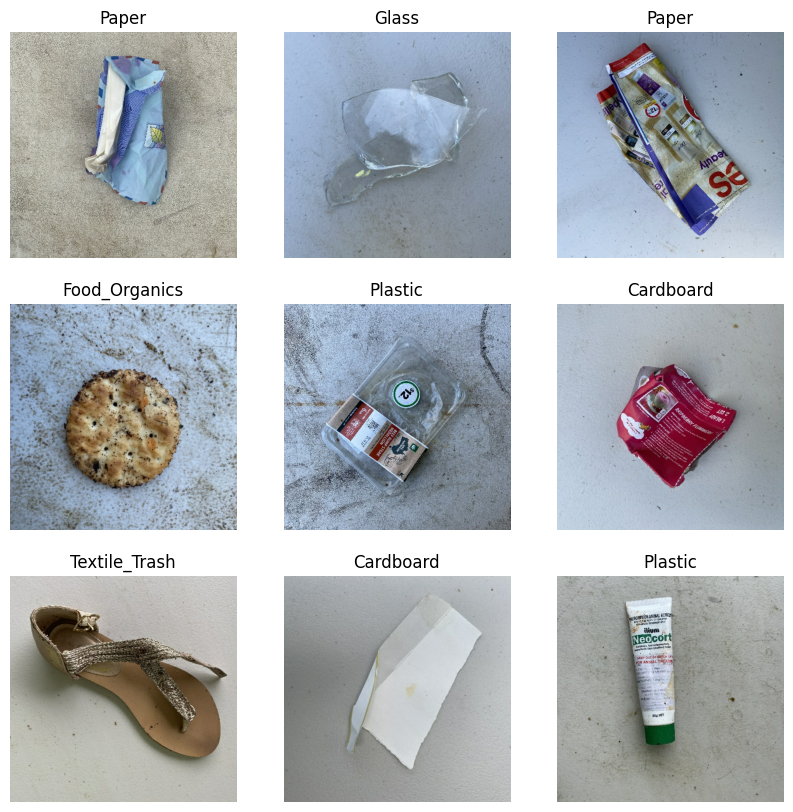

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [ ]:
pretrained_mobilenets = tf.keras.applications.MobileNet(include_top=False, input_shape=(524, 524, 3), weights='imagenet')
pretrained_mobilenets.trainable = False

for layer in pretrained_mobilenets.layers:
  layer.trainable = False

pretrained_mobilenets.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 524, 524, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 262, 262, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 262, 262, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 262, 262, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 262, 262, 32)      288       
 )                                                               
                                                 

In [ ]:
inputs = layers.Input((524, 524, 3), batch_size)
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = pretrained_mobilenets(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation='softmax')(x)

mobilenets_model = Model(inputs, outputs)
mobilenets_model.compile(optimizer=optimizers.Adamax(learning_rate=1e-4), loss=losses.CategoricalCrossentropy(), metrics=[metrics.F1Score(average='micro')])

In [ ]:
mobilenets_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 524, 524, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (32, 524, 524, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (32, 524, 524, 3)         0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 16, 16, 1024)      3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (32, 262144)              0         
                                                             

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset_real_waste/tf_mobilenets.keras', save_best_only=True, verbose=1)
history = mobilenets_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 1.6104 - f1_score: 0.4966
Epoch 1: val_loss improved from inf to 0.88313, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets.keras
87/87 [==============================] - 665s 8s/step - loss: 1.6104 - f1_score: 0.4966 - val_loss: 0.8831 - val_f1_score: 0.6826
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.7249 - f1_score: 0.7410
Epoch 2: val_loss improved from 0.88313 to 0.73456, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets.keras
87/87 [==============================] - 32s 356ms/step - loss: 0.7249 - f1_score: 0.7410 - val_loss: 0.7346 - val_f1_score: 0.7522
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.4985 - f1_score: 0.8305
Epoch 3: val_loss improved from 0.73456 to 0.64140, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets.keras
87/87 [==============================] - 38s 410ms/step - loss: 0.4985

In [ ]:
pretrained_mobilenets.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(pretrained_mobilenets.layers))

fine_tune_at = 40

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_mobilenets.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  86


In [ ]:
mobilenets_model.compile(optimizer=optimizers.Adamax(learning_rate=1e-5), loss=losses.CategoricalCrossentropy(), metrics=[metrics.F1Score(average='micro')])

In [ ]:
mobilenets_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 524, 524, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (32, 524, 524, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (32, 524, 524, 3)         0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 16, 16, 1024)      3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (32, 262144)              0         
                                                             

In [ ]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Dataset_real_waste/tf_mobilenets_finetune.keras', save_best_only=True, verbose=1)

history_fine = mobilenets_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds, callbacks=[cp_callback]
)

Epoch 11/20
87/87 [==============================] - ETA: 0s - loss: 0.0561 - f1_score: 0.9823
Epoch 11: val_loss improved from inf to 0.60264, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets_finetune.keras
87/87 [==============================] - 47s 463ms/step - loss: 0.0561 - f1_score: 0.9823 - val_loss: 0.6026 - val_f1_score: 0.8275
Epoch 12/20
87/87 [==============================] - ETA: 0s - loss: 0.0593 - f1_score: 0.9801
Epoch 12: val_loss improved from 0.60264 to 0.60126, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets_finetune.keras
87/87 [==============================] - 41s 455ms/step - loss: 0.0593 - f1_score: 0.9801 - val_loss: 0.6013 - val_f1_score: 0.8377
Epoch 13/20
87/87 [==============================] - ETA: 0s - loss: 0.0540 - f1_score: 0.9837
Epoch 13: val_loss improved from 0.60126 to 0.59069, saving model to /content/drive/MyDrive/Dataset_real_waste/tf_mobilenets_finetune.keras
87/87 [============================

In [ ]:
mobilenets_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset_real_waste/tf_mobilenets_finetune.keras')

## Predictions

In [ ]:
from types import NoneType
X_test = None
y_test = None

for x, y in val_ds:
  if type(X_test) == NoneType:
    X_test = x
    y_test = y
  else:
    X_test = np.concatenate((X_test, x))
    y_test = np.concatenate((y_test, y))

In [ ]:
predicted_labels = mobilenets_model.predict(X_test)

22/22 [==============================] - 5s 195ms/step


In [ ]:
predicted_labels = np.argmax(predicted_labels, axis=1)

In [ ]:
true_labels = np.argmax(y_test, axis=1)

In [ ]:
true_labels.shape, predicted_labels.shape

((690,), (690,))

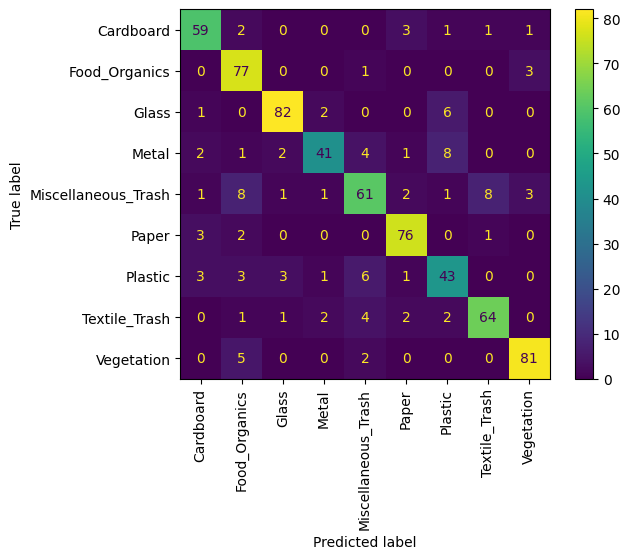

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', display_labels=val_ds.class_names)